In [1]:
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import pickle as pkl
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import os
import glob
import pandas as pd
import itertools
RANDOM_SEED=10

/pfs/lustrep4/scratch/project_462000187/home/getmanya/python_env_exp/cray_python/cray-python-virtualenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
path_root = "interspeech_2024_results"

def compute_silhouette_score(
    path_to_q_repr,
    path_to_predicted_ids,
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only",
):
    id_to_char_vocab = {value:key for (key,value) in char_to_id_vocab.items()}
    
    q_repr_no_project_q=torch.load(path_to_q_repr)
    predicted_ids = torch.load(path_to_predicted_ids)
    
    unique_predicted_ids_nonzero=torch.unique(predicted_ids[predicted_ids.nonzero()].squeeze())
    
    if q_representations=="all_unique":
        unique_repr,inverse_indices = torch.unique(q_repr_no_project_q.squeeze(),return_inverse=True,dim=0)
    elif q_representations=="nonzero":
        unique_repr,inverse_indices = torch.unique(q_repr_no_project_q[predicted_ids.nonzero()].squeeze(),return_inverse=True,dim=0)
        predicted_ids=predicted_ids[predicted_ids.nonzero()].squeeze()
    elif q_representations=="chars_only" or q_representations=="vowels_and_consonants" or q_representations=="only_finnish_chars":
        if q_representations=="only_finnish_chars":
            for char in char_to_id_vocab.keys():
                if char not in ['ä','ö','y']:
                    q_repr_no_project_q = q_repr_no_project_q[predicted_ids!=char_to_id_vocab[char]].squeeze()
                    predicted_ids=predicted_ids[predicted_ids!=char_to_id_vocab[char]].squeeze()
            unique_repr,inverse_indices = torch.unique(q_repr_no_project_q.squeeze(),return_inverse=True,dim=0)
        else:
            unique_repr,inverse_indices = torch.unique(q_repr_no_project_q[predicted_ids>4].squeeze(),return_inverse=True,dim=0)
            predicted_ids=predicted_ids[predicted_ids>4].squeeze()
    
    most_frequent_id_list = torch.zeros(0)
    for idx in range(unique_repr.shape[0]):
        unique_ids, counts_of_ids = torch.unique(predicted_ids[inverse_indices==idx],return_counts=True)
        most_frequent_id = unique_ids[torch.argmax(counts_of_ids)].item()
        most_frequent_id_list=torch.cat([most_frequent_id_list,torch.tensor([most_frequent_id])],dim=0)
    most_frequent_id_list=most_frequent_id_list.to(torch.long)
    if q_representations=="vowels_and_consonants":
        most_frequent_id_list = [0 if id_to_char_vocab[item.item()] in ['a', 'e', 'i', 'o', 'u', 'y', 'ä', 'ö', 'å'] else 1 for item in most_frequent_id_list]
    
    unique_predicted_ids = torch.unique(predicted_ids)
    most_frequent_id_list = np.array(most_frequent_id_list)

    compute_adjusted_mutual_info_score=True
    kmeans_clustering=True
    plot_kmeans=True
    save_fig=False
    
    print(f"# of unique char ids: {len(unique_predicted_ids)} ({q_representations})")
    n_clusters=len(unique_predicted_ids)
    
    best_n=2
    best_silhouette_score=0.0
    
    if kmeans_clustering:
        for n in range(245, 260, 1):
            kmeans = KMeans(n_clusters=n, random_state=RANDOM_SEED)
            score = silhouette_score(
                X=unique_repr,
                labels=kmeans.fit_predict(unique_repr),
                metric='cosine',
                sample_size=None,
                random_state=RANDOM_SEED
            )
            print(f"n={n}, score: {score}")
            if score>best_silhouette_score:
                best_n=n
                best_silhouette_score=score
        print(f"Best silhouette score: {best_silhouette_score} (n={best_n})")
        if plot_kmeans:
            kmeans = KMeans(n_clusters=best_n, random_state=RANDOM_SEED)
            labels=kmeans.fit_predict(unique_repr)
            if compute_adjusted_mutual_info_score:
                AMI_score=adjusted_mutual_info_score(np.array(labels), most_frequent_id_list)
                print(f"AMI score between the best clusterings and the character labels: {AMI_score}")
            score = silhouette_score(
                X=unique_repr,
                labels=labels,
                metric='cosine',
                sample_size=None,
                random_state=RANDOM_SEED
            )

            most_frequent_id_list_fin_vowels_only = most_frequent_id_list
            labels_fin_vowels_only = np.array(labels)
            for char in char_to_id_vocab.keys():
                if char not in ['ä','ö','y']:
                    labels_fin_vowels_only = labels_fin_vowels_only[most_frequent_id_list_fin_vowels_only!=char_to_id_vocab[char]]
                    most_frequent_id_list_fin_vowels_only =  most_frequent_id_list_fin_vowels_only[most_frequent_id_list_fin_vowels_only!=char_to_id_vocab[char]]
            AMI_score_fin_vowels_only=adjusted_mutual_info_score(labels_fin_vowels_only, most_frequent_id_list_fin_vowels_only)
            print(f"AMI score between the best clusterings and the Finnish vowels (ä, ö, y): {AMI_score_fin_vowels_only}")
            
            
            # print(labels)
            
            # color_idx_to_predicted_id_dict = {unique_predicted_ids[idx].item():idx
            #      for idx in range(unique_predicted_ids.shape[0])}
            # color_idx_to_predicted_id_dict = {unique_predicted_ids_nonzero[idx].item():idx
                 # for idx in range(unique_predicted_ids_nonzero.shape[0])}
            color_idx_to_predicted_id_dict = {labels[idx]:idx
                 for idx in range(len(labels))}
            
            color_palette = sns.color_palette(
                cc.glasbey,
                n_colors=best_n
            )
            
            mapper_one_char_per_repr = umap.UMAP(n_components = 2, metric='cosine').fit_transform(unique_repr)
            
            predicted_id_to_color_idx_dict = {value:key for (key,value) in color_idx_to_predicted_id_dict.items()}
            id_to_char_vocab = {value:key for (key,value) in char_to_id_vocab.items()}
            
            legend = list(color_idx_to_predicted_id_dict.keys())
            # lab = np.array(most_frequent_id_list)
            lab = np.array(labels)
            
            # if q_representations=="chars_only":
            #     # Exclude "|" from the legend
            #     i_range = range(1,len(legend))
            # else:
            i_range = range(len(legend))
            
            # print(i_range)
            # print(predicted_id_to_color_idx_dict)
                
            for i in i_range:
                idx = np.where(lab==i)
            #     print(i, np.sum(idx))
                plt.scatter(
                    mapper_one_char_per_repr[idx,0],
                    mapper_one_char_per_repr[idx,1],
                    s=0.08,
                    # label = id_to_char_vocab[predicted_id_to_color_idx_dict[i]],
                    label=i,
                    color = color_palette[i],
                )
            # plt.title("_".join(path_to_q_repr.split('/')[-1].split('_')[:-5]))
            
            # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 3, markerscale=16)
            umap_visualizations_save_dir = "interspeech_2024_results/visualizations/kmeans"
            if save_fig:
                plt.savefig(f"{umap_visualizations_save_dir}/{'_'.join(path_to_q_repr.split('/')[-1].split('_')[:-5])}.svg",bbox_inches='tight')
                plt.savefig(f"{umap_visualizations_save_dir}/{'_'.join(path_to_q_repr.split('/')[-1].split('_')[:-5])}.png",bbox_inches='tight')

        
    else:
        score = silhouette_score(
            X=unique_repr,
            labels=most_frequent_id_list,
            metric='cosine',
            sample_size=None,
            random_state=RANDOM_SEED
        )
        # print(f"n={n}, score: {score}")
    return score

# of unique char ids: 23 (chars_only)
n=150, score: 0.34052327275276184
n=151, score: 0.34266045689582825
n=152, score: 0.3402772545814514
Best silhouette score: 0.34266045689582825 (n=151)
AMI score between the best clusterings and the character labels: 0.14619954910824343
AMI score between the best clusterings and the Finnish vowels (ä, ö, y): 0.08793372501712197


0.34266046

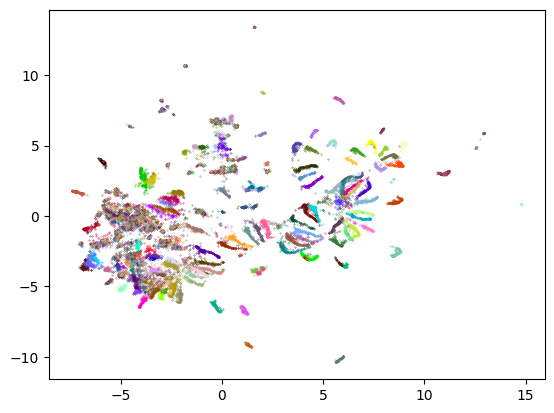

In [78]:
compute_silhouette_score(
    path_to_q_repr=f"{path_root}/wav2vec2_base_lp_from_scratch_q_repr.pt",
    path_to_predicted_ids=f"{path_root}/wav2vec2_base_lp_from_scratch_predicted_ids.pt",
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only"
)

# of unique char ids: 23 (chars_only)
n=175, score: 0.2604731023311615
n=176, score: 0.2631532549858093
n=177, score: 0.263274610042572
n=178, score: 0.26149389147758484
n=179, score: 0.2608022689819336
Best silhouette score: 0.263274610042572 (n=177)
AMI score between the best clusterings and the character labels: 0.2849423363540696
AMI score between the best clusterings and the Finnish vowels (ä, ö, y): 0.12304983628114242


0.2632746

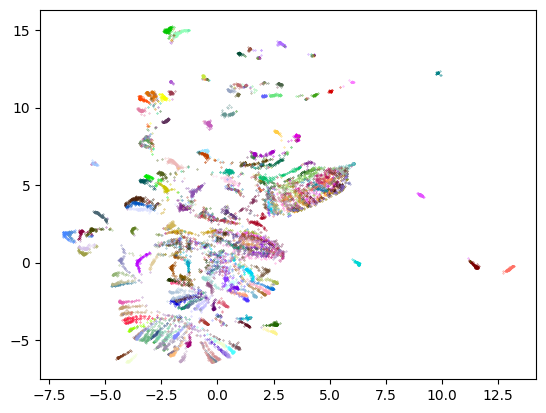

In [80]:
compute_silhouette_score(
    path_to_q_repr=f"{path_root}/wav2vec2_base_voxpopuli_finnish_q_repr.pt",
    path_to_predicted_ids=f"{path_root}/wav2vec2_base_voxpopuli_finnish_predicted_ids.pt",
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only"
)

# of unique char ids: 24 (chars_only)
n=150, score: 0.2604634165763855
n=151, score: 0.26013338565826416
n=152, score: 0.26071855425834656
n=153, score: 0.26077723503112793
n=154, score: 0.2609045207500458
n=155, score: 0.26164475083351135
n=156, score: 0.2627789080142975
n=157, score: 0.26156654953956604
n=158, score: 0.26036709547042847
n=159, score: 0.2598640024662018
Best silhouette score: 0.2627789080142975 (n=156)
AMI score between the best clusterings and the character labels: 0.31132121363226284
AMI score between the best clusterings and the Finnish vowels (ä, ö, y): 0.14385523322305677


0.2627789

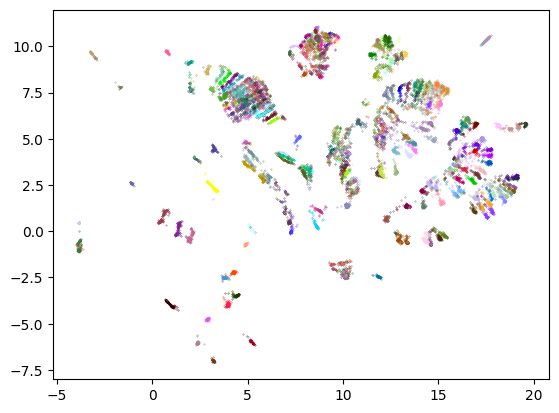

In [82]:
compute_silhouette_score(
    path_to_q_repr=f"{path_root}/wav2vec2_base_cont_pt_q_repr.pt",
    path_to_predicted_ids=f"{path_root}/wav2vec2_base_cont_pt_predicted_ids.pt",
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only"
)

# of unique char ids: 24 (chars_only)
n=75, score: 0.3558197319507599
n=76, score: 0.35435405373573303
n=77, score: 0.3575410544872284
n=78, score: 0.3659421503543854
n=79, score: 0.3596860468387604
n=80, score: 0.36237451434135437
n=81, score: 0.35396164655685425
n=82, score: 0.356633722782135
n=83, score: 0.3479633927345276
n=84, score: 0.3465367555618286
Best silhouette score: 0.3659421503543854 (n=78)
AMI score between the best clusterings and the character labels: 0.145870134538012
AMI score between the best clusterings and the Finnish vowels (ä, ö, y): 0.022683118958644572


0.36594215

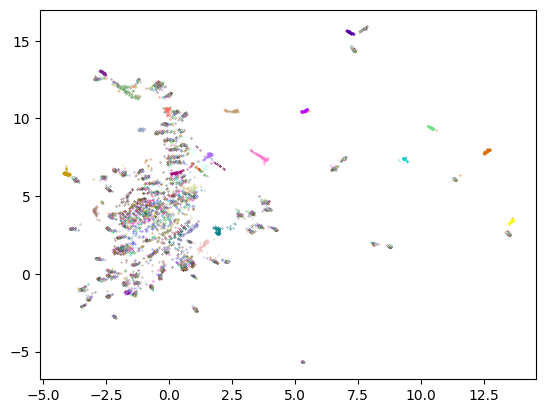

In [84]:
compute_silhouette_score(
    path_to_q_repr=f"{path_root}/wav2vec2_large_lp_from_scratch_q_repr.pt",
    path_to_predicted_ids=f"{path_root}/wav2vec2_large_lp_from_scratch_predicted_ids.pt",
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only"
)

# of unique char ids: 23 (chars_only)
n=240, score: 0.23594559729099274
n=241, score: 0.23527415096759796
n=242, score: 0.23671893775463104
n=243, score: 0.23757173120975494
n=244, score: 0.23678094148635864
n=245, score: 0.23548489809036255
n=246, score: 0.2372998744249344
n=247, score: 0.23504097759723663
n=248, score: 0.23462814092636108
n=249, score: 0.23709914088249207
Best silhouette score: 0.23757173120975494 (n=243)
AMI score between the best clusterings and the character labels: 0.2771647413419543
AMI score between the best clusterings and the Finnish vowels (ä, ö, y): 0.10375814467737202


0.23757173

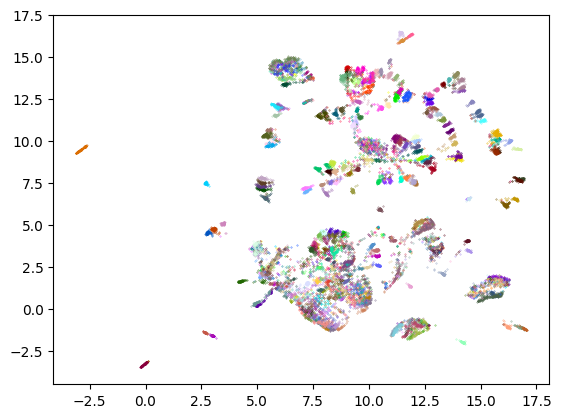

In [86]:
compute_silhouette_score(
    path_to_q_repr=f"{path_root}/wav2vec2_large_uralic_q_repr.pt",
    path_to_predicted_ids=f"{path_root}/wav2vec2_large_uralic_predicted_ids.pt",
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only"
)

# of unique char ids: 24 (chars_only)
n=245, score: 0.25067126750946045
n=246, score: 0.2515616714954376
n=247, score: 0.2495870143175125
n=248, score: 0.24995777010917664
n=249, score: 0.24992115795612335
n=250, score: 0.2505621910095215
n=251, score: 0.25151434540748596
n=252, score: 0.2519184350967407
n=253, score: 0.25029775500297546
n=254, score: 0.25010940432548523
n=255, score: 0.2506091892719269
n=256, score: 0.2507319450378418
n=257, score: 0.24898838996887207
n=258, score: 0.2489684522151947
n=259, score: 0.24797074496746063
Best silhouette score: 0.2519184350967407 (n=252)
AMI score between the best clusterings and the character labels: 0.3022213293509262
AMI score between the best clusterings and the Finnish vowels (ä, ö, y): 0.1282795787014538


0.25191844

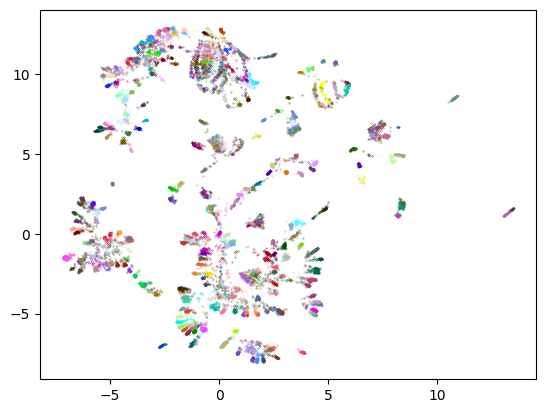

In [88]:
compute_silhouette_score(
    path_to_q_repr=f"{path_root}/wav2vec2_large_cont_pt_q_repr.pt",
    path_to_predicted_ids=f"{path_root}/wav2vec2_large_cont_pt_predicted_ids.pt",
    char_to_id_vocab={"</s>": 2,"<pad>": 0,"<s>": 1,"<unk>": 3,"a": 16,"b": 27,"c": 28,"d": 23,"e": 19,"f": 26,"g": 25,"h": 8,"i": 9,"j": 11,"k": 21,"l": 20,"m": 18,"n": 10,"o": 7,"p": 15,"q": 31,"r": 22,"s": 17,"t": 14,"u": 6,"v": 5,"w": 30,"x": 32,"y": 13,"z": 29,"|": 4,"ä": 12,"å": 33,"ö": 24},
    q_representations="chars_only"
)